# Unscented Kalman Filters 

In [2]:
# With this backend, the output of plotting commands is displayed 
# inline within frontends, directly below the code cell that produced it
%matplotlib inline

Nonlinearity can appear in two places: in measurements or in the process model. 
In measurements the nonlinearity is due to noises too difficult and unpredictable to be considered and accurately modeled - for example, with RSSI measurements, the reflection of the signal on the walls of a building, an object obstructing two sensors or even the placement of the antennas of the sensors may change the RSSI value. 
These noises are intrinsecally nonlinear. 
Another element of nonlinearity is the process model itself for a certain phenomena. 
If we are tracking a ball traveling through the air, the effects of air drag lead to non-linear behaviour. 

The Standard Kalman Filter performs poorly or not at all with these sorts of problems as it is thought for linear optimization. 

The Extended Kalman Filter, while considering non-linear models, linearizes them by producing a Jacobian Matrix at each iteration, which is computationally expensive. 

We will now study the use of Uscented Kalman Filters.

Let's first see an example of non-linear plot, to emphasize the effects of nonlinearity. 

The definition of a nonlinear function is a function that does not graph into a straight line and does not have a constant slope, of form

 $f(x) = ax + b$

So let's first plot an example of nonlinear function

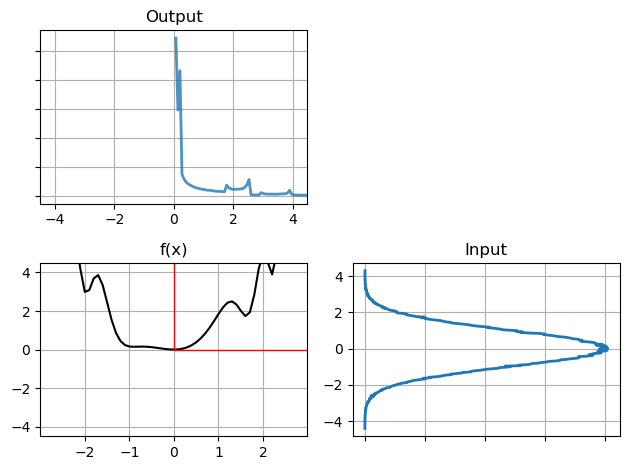

In [31]:
import matplotlib.pyplot as plt 
from numpy.random import normal, multivariate_normal
import numpy as np 
import scipy.stats 

# create 500000 samples with mean 0, std 1
gaussian = (0., 1.)
data = normal(loc = gaussian[0], scale= gaussian[1], size= 500000)

def nonlinear_function(x): 
    return x**2 + np.sin(x**3)

y_values = nonlinear_function(data)
x0 = np.mean(data)
in_std = np.std(data)

y = nonlinear_function(x0)
std = np.std(y_values)

in_lims = [x0 - in_std*3, x0 + in_std*3]
out_lims = [y - std*3, y + std*3]

# plotting output
h = np.histogram(y_values, 300, density = False)
plt.subplot(2, 2, 1)
plt.plot(h[1][1:], h[0], lw = 2, alpha=0.8)

plt.xlim(out_lims[0], out_lims[1])
plt.gca().yaxis.set_ticklabels([])
plt.grid(True)
plt.title('Output')

#plt.axvline(np.mean(y_values), ls='--', lw=2)
#plt.axline(nonlinear_function(x0), lw=1)

norm = scipy.stats.norm(y, in_std)

# plottinh the transfer function 
plt.subplot(2,2,3)
x = np.arange(in_lims[0], in_lims[1], 0.1)
y = nonlinear_function(x)

plt.plot(x, y, 'k')
isct = nonlinear_function(x0)
plt.plot([x0, x0, in_lims[1]], [out_lims[1], isct, isct], color='r', lw=1)
plt.xlim(in_lims)
plt.ylim(out_lims)
plt.grid(True)
plt.title('f(x)')

#plot input 
h = np.histogram(data, 300, density = True)

plt.subplot(2,2,4)
plt.plot(h[0], h[1][1:], lw=2)
plt.gca().xaxis.set_ticklabels([])
plt.title('Input')
plt.tight_layout()
plt.grid(True)
plt.show()



f(x) is the nonlinear transformation function chosen. 
The input follows a gaussian distribution with mean zero and the result
is computed by sampling 500000 points from the imput and builduing a 
histogram of the result. 
These points are called **sigma points**. 

From the computed output histogram we can compute a mean and 
a standard deviation which would give us an updated, approximated gaussian. 

Let's see a scatter plot of the points (data) before and after 
having passed the nonlinear function

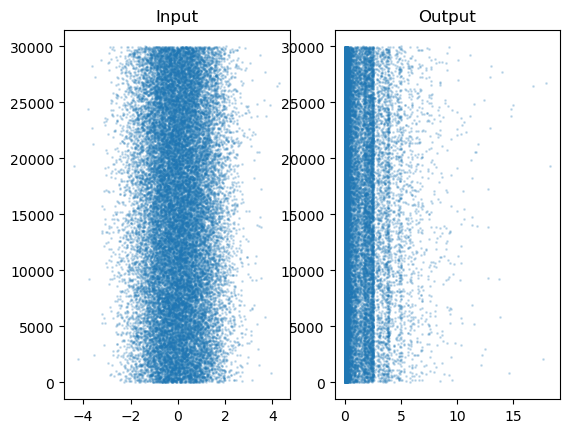

In [32]:
N = 30000
plt.subplot(121)
plt.scatter(data[:N], range(N), alpha=.2, s=1)
plt.title('Input')
plt.subplot(122)
plt.title('Output')
plt.scatter(nonlinear_function(data[:N]), range(N), alpha=.2, s = 1)

As we can see the input data follows a Gaussian, as it was so generated.
The noise scatters around a zero mean.
On the other hand, the data output from the nonlinear function has a 
defined structure. 

The sampling approach is called Monte Carlo approach and it is used by some Kalman Filter designs, such as the particle filter.
Sampling requires no specialized knowledge, and does not require a closed form solution. No matter how non-linear or poorly behaved the function is, as long as we sample with enough sigma points we will build an accurate output distribution. 

The problem rises with the concept of "enough points". The graph above was created with 500000 points and the output is still not smooth. What's worse, this is only considering 1 dimension. 
The number of points required increases by the power og the number of dimensions. 
So, while this method works, it is very computationally expensive. 

The Uscented Kalman Filter uses sigma points but drastically reduces the amount of computation by using a deterministic method to choose the relevant points. 

## Sigma Points - Sampling from a Distribution

Let's look at the problem in terms of a 2D covariance ellipse. 
Assuming some arbitrary nonlinear function, we will take random points from the first covariance ellipse, pass them through the nonlinear function, and plot their new position. 
Then we can compute mean and covariance of the transformed points, and use that as our estimate of the mean and probability distribution. 

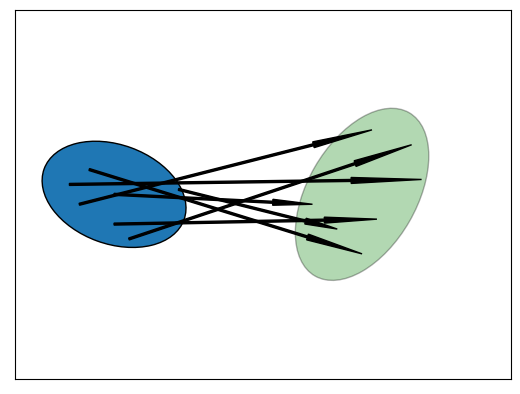

In [38]:
from matplotlib.patches import Ellipse, Arrow

def arrow(x1,y1,x2,y2, width=0.2):
    return Arrow(x1,y1, x2-x1, y2-y1, lw=1, width=width, ec='k', color='k')

plt.cla()
ax = plt.gca()

ax.add_artist(Ellipse(xy=(2,5), width=2, height=3,angle=70,linewidth=1,ec='k'))
ax.add_artist(Ellipse(xy=(7,5), width=2.2, alpha=0.3, height=3.8,angle=150,fc='g',linewidth=1,ec='k'))

ax.add_artist(arrow(2, 5, 6, 4.8))
ax.add_artist(arrow(1.5, 5.5, 7, 3.8))
ax.add_artist(arrow(2.3, 4.1, 8, 6))
ax.add_artist(arrow(3.3, 5.1, 6.5, 4.3))
ax.add_artist(arrow(1.3, 4.8, 7.2, 6.3))
ax.add_artist(arrow(1.1, 5.2, 8.2, 5.3))
ax.add_artist(arrow(2, 4.4, 7.3, 4.5))

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

plt.axis('equal')
plt.xlim(0,10); plt.ylim(0,10)
plt.show()



On the left, ellipse with one sigma distribution for two state variables. 
The arrows show how many randomly sampled points might be transformed by some arbitraty nonlinear function to a new distribution.
The ellipse on the right indicates the estimate of mean and variance of the collected points. 

Lets write a function that passes 10000 sampled points randomly drawn from a Gaussian with mean and covariance: 

$ \mu = \begin{bmatrix} 0 \\ 0 \end{bmatrix}, 
\Sigma = \begin{bmatrix} 32 & 15 \\ 15 & 40 \end{bmatrix}
$


Through the nonlinear system: 

$$ 
\begin{cases} \overline{x} = y + x \\ \overline{y} = 0.1x^2 + y^2
\end{cases}



C:\Users\giuli\AppData\Local\Temp\ipykernel_19500\537691452.py:28: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=False)
C:\Users\giuli\AppData\Local\Temp\ipykernel_19500\537691452.py:37: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=False)


Difference in mean x=0.002, y=43.309


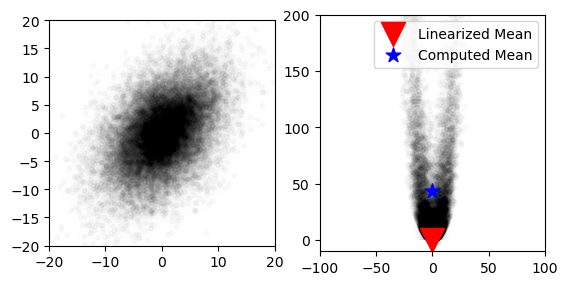

In [53]:
import numpy as np
from numpy.random import multivariate_normal

def plot_bivariate_colormap(xs, ys):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    xmin = xs.min()
    xmax = xs.max()
    ymin = ys.min()
    ymax = ys.max()
    values = np.vstack([xs, ys])
    kernel = scipy.stats.gaussian_kde(values)
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])

    Z = np.reshape(kernel.evaluate(positions).T, X.shape)
    plt.gca().imshow(np.rot90(Z), cmap=plt.cm.Greys,
                     extent=[xmin, xmax, ymin, ymax])


def plot_monte_carlo_mean(xs, ys, f, mean_fx, label, plot_colormap=True):
    fxs, fys = f(xs, ys)

    computed_mean_x = np.average(fxs)
    computed_mean_y = np.average(fys)

    ax = plt.subplot(121)
    ax.grid(b=False)

    plot_bivariate_colormap(xs, ys)

    plt.scatter(xs, ys, marker='.', alpha=0.02, color='k')
    ax.set_xlim(-20, 20)
    ax.set_ylim(-20, 20)

    ax = plt.subplot(122)
    ax.grid(b=False)

    plt.scatter(fxs, fys, marker='.', alpha=0.02, color='k')
    plt.scatter(mean_fx[0], mean_fx[1],
                marker='v', s=300, c='r', label=label)
    plt.scatter(computed_mean_x, computed_mean_y,
                marker='*',s=120, c='b', label='Computed Mean')

    plot_bivariate_colormap(fxs, fys)
    ax.set_xlim([-100, 100])
    ax.set_ylim([-10, 200])
    plt.legend(loc='best', scatterpoints=1)
    print ('Difference in mean x={:.3f}, y={:.3f}'.format(
           computed_mean_x-mean_fx[0], computed_mean_y-mean_fx[1]))
    

def f_nonlinear_xy(x, y): 
    return np.array([x + y, .1*x**2 + y*y])

mean = (0., 0.)
p = np.array([[32., 15.], [15., 40.]])
# compute linearized mean
mean_fx = f_nonlinear_xy(*mean)

#generate random points from it
xs, ys = multivariate_normal(mean=mean, cov=p, size = 10000).T

plot_monte_carlo_mean(xs, ys, f_nonlinear_xy, mean_fx, 'Linearized Mean')

As can be seen by the plot, linearizing the function might result in a large error (Extended Kalman Filters adopt this technique)

Linearized mean is simply calculating the mean of the output from the mean of the input. 
Using Monte Carlo we sample points following the input distribution and based off their distribution in the output a new mean and 
standard deviation are calculated. 

## A Quick Example

Before delving into the math the Unscented Kalman Filter (UKF) uses to choose the sigma points to performe the computation, let's start with an example.

UKF can use many different algorithms to generate sigma points. Several are provided by FilterPy. 
Here a possibility:

ModuleNotFoundError: No module named 'filterpy'